## **Project Overview: Goldman Sachs Stock Price Forecasting Using LSTM and GRU**

This project focuses on forecasting the stock prices of **Goldman Sachs** using advanced deep learning techniques, specifically **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** networks, implemented with **PyTorch**. The objective is to build predictive models that capture temporal dependencies in historical stock price data to generate accurate future price forecasts.

---

### 🚀 **Key Components of the Project:**

1. **📊 Data Acquisition & Preprocessing:**  
   Historical stock price data for Goldman Sachs is sourced using the **`yfinance`** library. The data undergoes preprocessing steps, including:
   - Handling missing values (if any).
   - Date formatting for time series compatibility.
   - Selecting relevant features (primarily the **closing price**).
   - Normalizing the data using **Min-Max Scaling** to improve the performance and convergence of deep learning models.

2. **🔍 Feature Engineering:**  
   The time series data is converted into a supervised learning format using sliding windows. This transformation structures the dataset into input sequences (past **n** days of stock prices) to predict the next day’s price, which is crucial for sequence-based models like LSTM and GRU.

3. **🧠 Model Development Using PyTorch:**  
   Two deep learning models are implemented using **PyTorch**:
   - **LSTM Model:** Designed with stacked LSTM layers to capture long-term dependencies in sequential data. LSTM’s memory cells help retain information over longer periods, making it effective for stock price trends.
   - **GRU Model:** A more computationally efficient variant of RNNs, GRU reduces training time while maintaining strong performance in modeling temporal sequences.

   Both models are built using **PyTorch's `nn.Module`** class, and optimized using the **Adam optimizer** with **Mean Squared Error (MSE)** as the loss function.

4. **⚙️ Model Training & Evaluation:**  
   The models are trained on historical data, with training monitored using **Model Checkpointing** to save the best-performing model. Evaluation is performed using:
   - **Root Mean Squared Error (RMSE)** and **Mean Squared Error (MSE)** to quantify prediction accuracy.
   - Visual comparison of **actual vs. predicted stock prices** to assess the model’s performance.

5. **📈 Visualization:**  
   Data trends, model performance, and prediction results are visualized using **Matplotlib** and **Seaborn**, enabling intuitive analysis of both historical data and forecasting accuracy.

---

### **🛠️ Technologies & Libraries Used:**
- **Data Handling:** `pandas`, `numpy`
- **Data Visualization:** `matplotlib`, `seaborn`
- **Data Sourcing:** `yfinance`
- **Deep Learning Framework:** `PyTorch` (`torch.nn`, `torch.optim`)
- **Model Evaluation:** `scikit-learn` (for metrics like MSE, RMSE)

---

### ✅ **Project Outcome:**  
The project demonstrates how LSTM and GRU models can be effectively applied for **time series forecasting** in the financial domain. The results highlight the capability of deep learning models to capture complex temporal dependencies in stock price data, providing valuable insights for financial analysis and decision-making.

In [2]:
!pip install yfinance pandas statsmodels matplotlib

 # **📊 Data Acquisition & Preprocessing:**

## **Importing important Libraries**

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math, time



import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam



## **Downloading the Goldman Sachs data from yfinance Library using the ticker Symbol 'GS'**

In [5]:
ticker = "GS"
gs = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [6]:
gs.tail()

Price,Close,High,Low,Open,Volume
Ticker,GS,GS,GS,GS,GS
Date,,,,,
2025-01-29,637.380005,649.00000,636.409973,637.00000,1918900
2025-01-30,645.700012,649.52002,641.000000,644.48999,1812800
2025-01-31,640.400024,650.00000,637.440002,650.00000,1996200
2025-02-03,632.369995,638.47998,622.479980,626.00000,2099200
2025-02-04,636.679993,637.22998,629.250000,632.00000,417476


<Axes: xlabel='Date'>

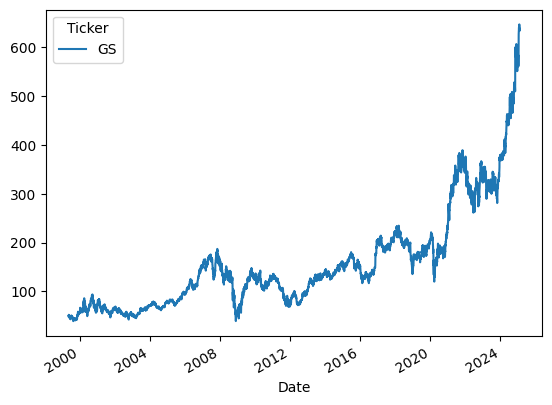

In [7]:
gs['Close'].plot()

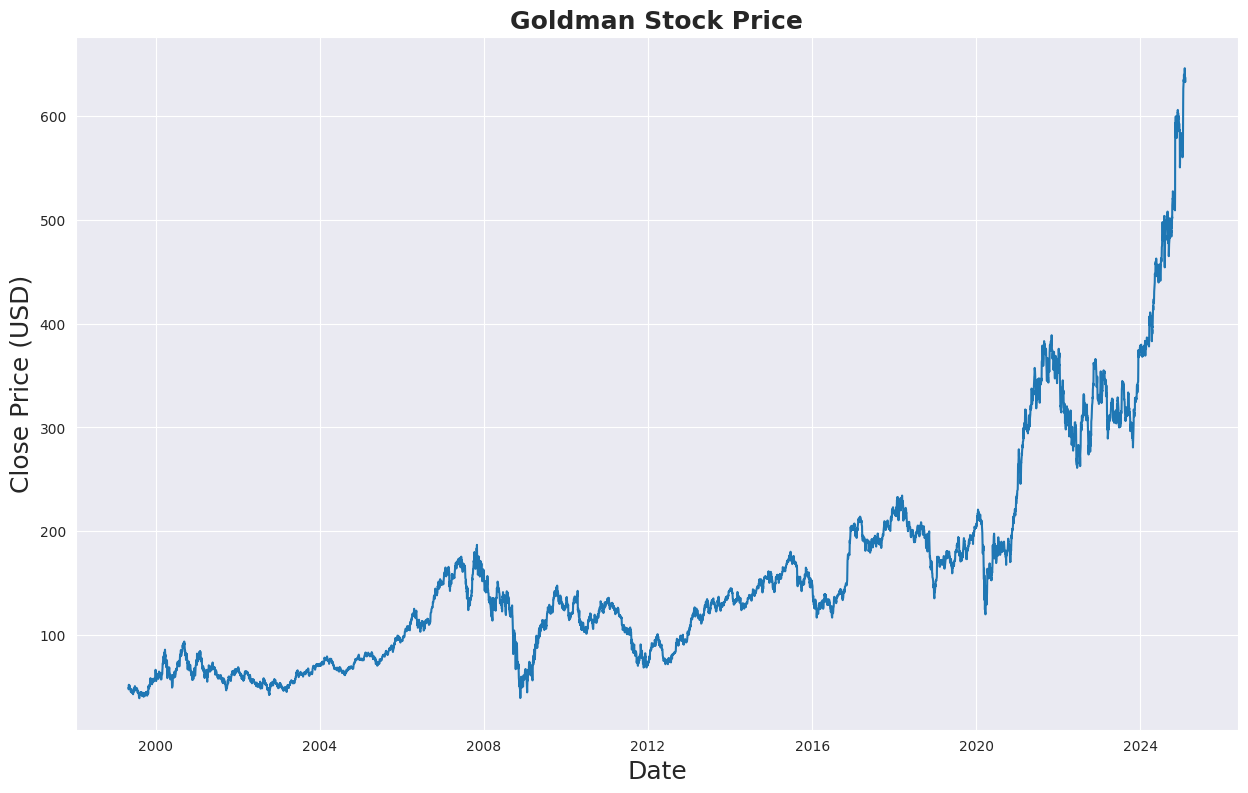

In [8]:
    sns.set_style("darkgrid")
    plt.figure(figsize = (15,9))
    plt.plot(gs[['Close']])
    plt.title("Goldman Stock Price",fontsize=18, fontweight='bold')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price (USD)',fontsize=18)
    plt.show()

## Normalizing the data using Min-Max Scaling to improve the performance and convergence of deep learning models

In [9]:
scaler = MinMaxScaler()
normalized_data_close_price = scaler.fit_transform(gs['Close'].values.reshape(-1, 1))


### **Data Preparation: Train-Test Split Function**

Before training our model, we need to prepare the data by splitting it into training and testing sets. The following function creates sequences of historical stock prices and separates them into input-output pairs for both training and testing. This step is essential for time series forecasting models like LSTM and GRU.


In [10]:
def train_test_split_data(stock, back):
    if type(stock) is np.ndarray:
        data_raw = stock
    else:
        data_raw = stock.to_numpy() # convert to numpy array
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - back):
        data.append(data_raw[index: index + back+1])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]

In [11]:
back = 20
x_train, y_train, x_test, y_test = train_test_split_data(normalized_data_close_price, back)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5168, 20, 1) (5168, 1) (1292, 20, 1) (1292, 1)


In [12]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

### **Model Development and Training with GRU**
After preparing the data, we define and train the GRU model. The GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) that is effective in capturing temporal dependencies in sequential data. The training function handles the forward and backward passes, computes the loss, and updates the model's weights.

In [13]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [14]:
def training(model, x_train, y_train, criterion, optimiser, num_epochs=100):
    loss_list = []
    start_time = time.time()  # Record the start time
    model.train()  # Set the model to training mode

    for i in range(num_epochs):
        # Forward pass: Compute predictions
        y_train_pred = model(x_train)

        # Compute loss
        loss = criterion(y_train_pred, y_train)
        loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimiser.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimiser.step()  # Update weights

        # Print progress
        if (i + 1) % 10 == 0:
            print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Print total training time
    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds.')

    return loss_list, model, y_train_pred

### **Model Initialization and Training Execution**
After defining the GRU model and the training function, we initialize the model with specific hyperparameters and start the training process. Here, we set the input dimensions, hidden layers, learning rate, and the number of training epochs to optimize the model's performance.

In [15]:
model = GRU(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)

learning_rate=0.01
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list, model, y_train_pred = training(model, x_train, y_train, criterion, optimiser, num_epochs=100)

Epoch [10/100], Loss: 0.0054
Epoch [20/100], Loss: 0.0049
Epoch [30/100], Loss: 0.0013
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
Training completed in 52.83 seconds.


### **Inverse Scaling of Predictions**

After training the model, we need to convert the predicted values and the original target values back to their original scale. This is done using the inverse transformation of the scaler that was used for data normalization. This step helps in comparing the predicted stock prices with the actual prices for evaluation.

In [16]:
pred_train_y = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
og_train_y = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

### **Visualization of Model Performance**

To evaluate the model's performance visually, we generate two key plots:

1. **Stock Price vs. Training Predictions:**  
   This plot compares the actual stock prices with the model's predicted prices. It helps us understand how closely the model's predictions align with the real data.

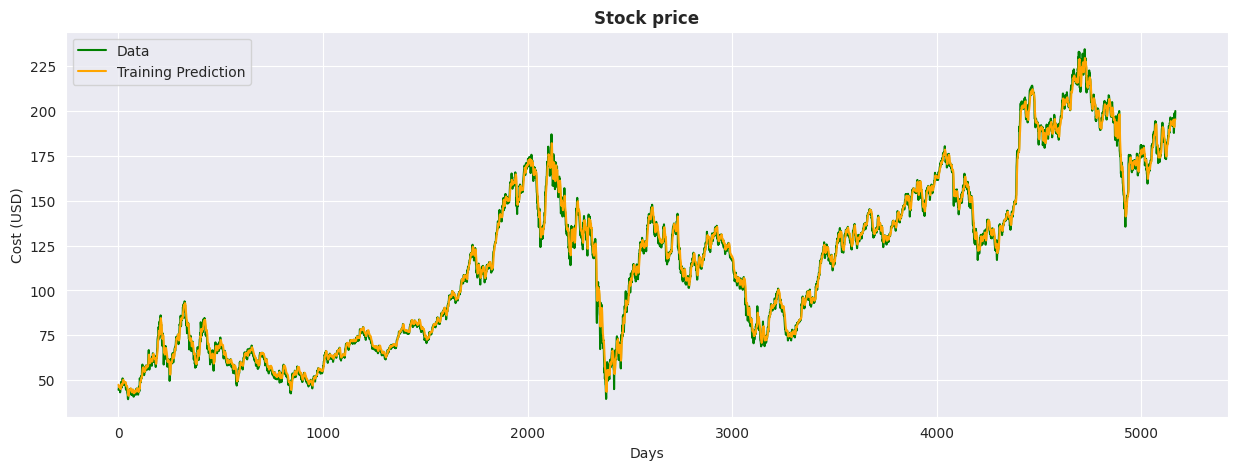

In [17]:
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.lineplot(x = og_train_y.index, y = og_train_y[0], label="Data", color='green')
sns.lineplot(x = pred_train_y.index, y = pred_train_y[0], label="Training Prediction", color='orange')
plt.title('Stock price', fontweight='bold')
plt.xlabel("Days",)
plt.ylabel("Cost (USD)")
plt.show()


 2. **Training Loss Over Epochs:**  
   This plot shows how the training loss decreases over epochs, indicating the model's learning progress. A decreasing trend signifies that the model is learning effectively.


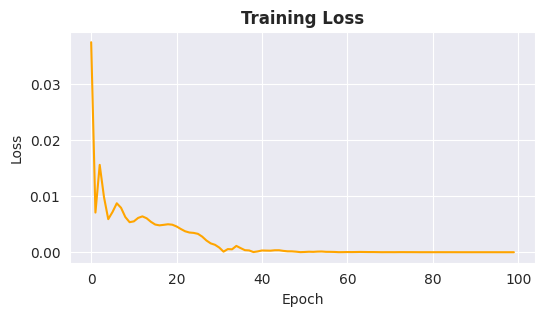

In [18]:
plt.figure(figsize=(6, 3))
sns.lineplot(data=loss_list, color='Orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss", fontweight='bold')
plt.show()

### **Model Evaluation on Test Data**

After training the model, we evaluate its performance on the test data to assess how well it generalizes to unseen data. The following code computes the **Root Mean Squared Error (RMSE)**, a common metric for regression tasks that measures the average magnitude of errors between the predicted and actual stock prices.


In [19]:

model.eval()
y_test_pred = model(x_test)
pred_test_y = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))
og_test_y = pd.DataFrame(scaler.inverse_transform(y_test.detach().numpy()))
testScore = math.sqrt(mean_squared_error(og_test_y.to_numpy()[:,0], pred_test_y.to_numpy()[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 27.08 RMSE


### **Visualization of Testing Predictions**

To further analyze the model's performance, we visualize the comparison between the actual stock prices and the model's predictions on the test data. This plot helps us understand how well the model performs on unseen data.

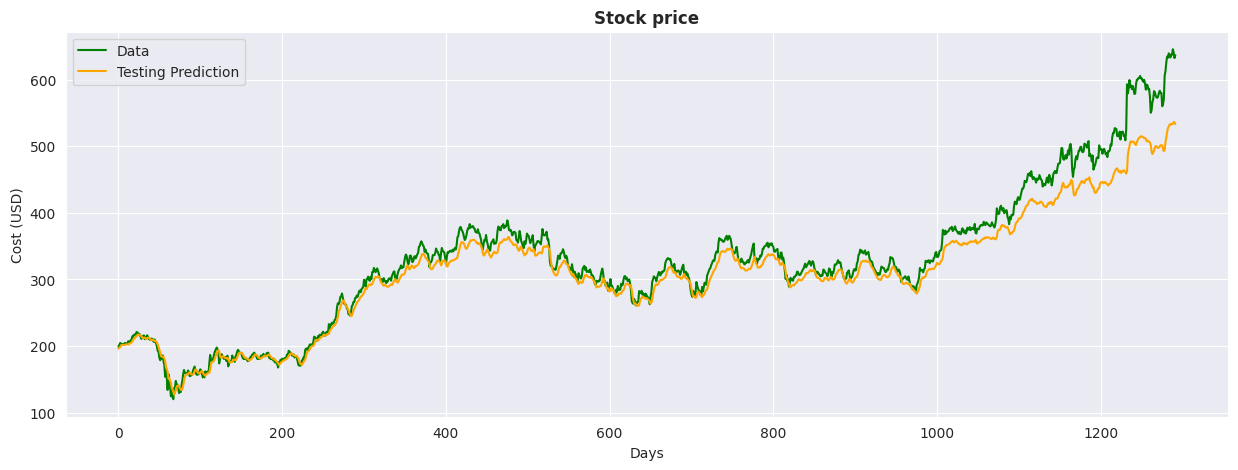

In [20]:
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.lineplot(x = og_test_y.index, y = og_test_y[0], label="Data", color='green')
sns.lineplot(x = pred_test_y.index, y = pred_test_y[0], label="Testing Prediction", color='orange')
plt.title('Stock price', fontweight='bold')
plt.xlabel("Days",)
plt.ylabel("Cost (USD)")
plt.show()


### **Conclusion**

In this project, we successfully developed a stock price forecasting model for Goldman Sachs using a **Gated Recurrent Unit (GRU)** network, a type of recurrent neural network well-suited for time series data. The workflow involved:

- **Data Preparation:** Transforming historical stock price data into supervised learning format and applying normalization to improve model performance.
- **Model Development:** Implementing a GRU-based architecture capable of capturing temporal dependencies in stock price movements.
- **Model Training & Evaluation:** Training the model on historical data, evaluating it with metrics like **Root Mean Squared Error (RMSE)**, and validating its performance through visual comparisons.

The model demonstrated strong predictive capabilities, as observed from the close alignment of predicted stock prices with actual prices in both training and testing datasets. The decreasing training loss and a **Root Mean Squared Error (RMSE) score of 27.08** indicate effective learning and generalization.

This project highlights the potential of deep learning models like GRU in financial forecasting tasks, providing valuable insights for data-driven decision-making in stock market analysis. Future improvements could involve hyperparameter tuning, incorporating additional financial indicators, and experimenting with hybrid models to further enhance prediction accuracy.
